# DELETWEET SENTIMENT ANALYSIS

***

In [1]:
import json
import pandas
import matplotlib
import nltk.classify.util
from nltk.corpus import twitter_samples
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18.0, 12.0]

***
## *TRAIN CLASSIFIER*

NLTK provides a [HOW-TO](http://www.nltk.org/howto/twitter.html) which serves as a tutorial for using their built-in classes to interact with the Twitter API and gather a tweet corpus to use for text mining and natural language processing. They also provide their own Twitter corpus which consists of three separate sections: the first is a random collection of tweets gathered within a certain timeframe under certain search parameters. The other two are collections of 5,000 tweets each, classified as expressing positive and negative sentiment respectively.

Interestingly the tweets were gathered and classed by searching for text emojis relevant to the desired emotion. For example, tweets containing emojis such as :-), :), ;), :o), :] were classified as positive, while tweets containing emojis like :L, :<, :-(, >.< were classified as negative. The negative class has [in my opinion] more potentially neutral - or just non-negative - emojis than the positive class, such as :S, :@ and =/. This could lead to more neutral texts being classified as negative, which we will see happen later on.

For training our Naive Bayes Classifier we used StreamHacker's [series of blog posts](http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/) as a guide. The interface to the classifier is provided by NLTK, as is the tokenized version of the tweet corpus. However, we normalized their provided tweet corpus by converting the tokenized text to lowercase before training, which greatly improved the relevance of the classifier's most informative features.

In [2]:
def word_feats(words):
    '''
    this function borrowed from: http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/

    "All of the NLTK classifiers work with featstructs, which can be simple dictionaries
    mapping a feature name to a feature value. For text, we’ll use a simplified
    bag of words model where every word is feature name with a value of True."
    '''

    return dict([(word, True) for word in words])

In [3]:
# pull out tokenized text from the classified tweets provided by NLTK
# more info: http://www.nltk.org/howto/twitter.html#Using-a-Tweet-Corpus
tokenized_negative = twitter_samples.tokenized('negative_tweets.json')
tokenized_positive = twitter_samples.tokenized('positive_tweets.json')

In [4]:
# normalize text by transforming to lowercase
negatives_normalized = [[word.lower() for word in thing] for thing in tokenized_negative]
positives_normalized = [[word.lower() for word in thing] for thing in tokenized_positive]

In [5]:
# pass tokenized text through wordfeats() to convert into featstructs for NLTK classifier
negatives = [(word_feats(negatives_normalized[i]), 'neg') for i in range(len(tokenized_negative))]
positives = [(word_feats(positives_normalized[i]), 'pos') for i in range(len(tokenized_positive))]

In [6]:
# split dataset into 75% train/25% test
neg_split = int(len(negatives) * 0.75)
pos_split = int(len(positives) * 0.75)
train_feats = negatives[:neg_split] + positives[:pos_split]
test_feats = negatives[neg_split:] + positives[pos_split:]
print('train on {} instances, test on {} instances'.format(len(train_feats), len(test_feats)))

train on 7500 instances, test on 2500 instances


In [8]:
# train the classifier and determine its accuracy
classifier = NaiveBayesClassifier.train(train_feats)
print('accuracy: {:.2%}'.format(nltk.classify.util.accuracy(classifier, test_feats)))

accuracy: 99.36%


In [9]:
# show the features the classifier determined were most informative for classification
classifier.show_most_informative_features(40)

Most Informative Features
                      :( = True              neg : pos    =   2214.3 : 1.0
                      :) = True              pos : neg    =   1073.8 : 1.0
                    glad = True              pos : neg    =     25.7 : 1.0
                     x15 = True              neg : pos    =     23.7 : 1.0
                 arrived = True              pos : neg    =     21.8 : 1.0
                     sad = True              neg : pos    =     21.2 : 1.0
                    sick = True              neg : pos    =     19.7 : 1.0
               community = True              pos : neg    =     15.7 : 1.0
                   loves = True              pos : neg    =     14.1 : 1.0
                     ugh = True              neg : pos    =     13.7 : 1.0
                    miss = True              neg : pos    =     13.3 : 1.0
                      aw = True              neg : pos    =     13.0 : 1.0
              definitely = True              pos : neg    =     13.0 : 1.0

After training we can see that the classifier's most informative features are indeed good indicators for text sentiment. Words such as 'loves', 'appreciate', 'enjoy', 'welcome', 'great', and 'thank' are all correctly identified as expressing positive sentiment, while words such as 'sad', 'sick', 'ugh', 'hurts', and 'sorry' are indicative of negative sentiment. The text emojis :) and :( are the strongest indicators of positive and negative sentiment respectively, which makes sense given how the tweets were chosen and classified initially. Interestingly the 2 twitter users @justinbieber and @uber are both associated with negative sentiment, which may be an indicator of popular public opinion of those two users at the time the tweets were gathered. These features also suggest that if our classifier extends poorly to tweets in the wild, we might need to do more preprocessing of the training set, such as removing special characters and twitter users. It is worth noting that the NLTK tweet tokenizer has an optional parameter that allows for the removal of twitter usernames from the text during tokenization.

***
## *CLASSIFY DATASET*

Here we use our trained Naive Bayes classifier to classify the Politwoops dataset of deleted tweets. Before classification we again use the word_feats() function to construct a featstruct out of our tokenized dataset for the classifier, as we did with NLTK's corpus before training.

In [10]:
# import dataset
deletweet = pandas.read_csv('../../deletweet/data/deleted_tweets_cleaned.csv')

In [11]:
# construct a list of strings to hold the tweet text
tweet_text_raw = []

for i in range(len(deletweet)):
    tweet = json.loads(deletweet['tweet'][i])
    tweet_text_raw.append(tweet['text'])

In [12]:
# number of individual tweets to classify
len(tweet_text_raw)

67756

In [13]:
# use the tweet tokenizer provided by NLTK
# preserve_case=False will transform all to lowercase
tknzr = TweetTokenizer(preserve_case=False)
tokenized = [tknzr.tokenize(tweet_text_raw[i]) for i in range(len(tweet_text_raw))]

In [14]:
# run tokenized lists through word_feats() to construct featstruct for NLTK classifier
features = [word_feats(tokenized[i]) for i in range(len(tokenized))] 

In [15]:
# classify!
classed = classifier.classify_many(features)

In [16]:
classified_tweets = list(zip(classed, tweet_text_raw))

***
## *PLOT AND ANALYSIS*

The first 30 tweets from the Politwoops dataset are printed out below, along with their classified sentiment. After reading through these and other subsets of the classified dataset we can see that the classifier performs fairly well, although not perfectly, as indicated by the very first tweet being misclassified as negative. There is definite room for improvement, and a more robust feature set for training would likely go a long way. Expanding on the original search by specifically gathering tweets of a political nature in association with positive and negative text emojis would likely help ameliorate the deficiencies of the classifier.

Also after examining these results, it seems that the biggest improvement would come from the addition of a third neutral class: many of the tweets are ambiguous in sentiment, and therefore do not fit well into either the positive or negative classes.

In [17]:
for i in range(30):
    print('{} : {}'.format(classified_tweets[i][0], classified_tweets[i][1]))

neg : This is so cool. This same sort of adaptive protocol is being used with shipping drones as well. https://t.co/pLuU2ljAmg
pos : https://t.co/V7Rc07GrJU
pos : #TBT @MikePenceVP https://t.co/tSZUjMjaaI
pos : I had a cordial and candidate discussion today with the new DHS Secretary, John Kelly. https://t.co/4neFHS3Mji
pos : Grt to host @USProgressives Specl Order w/@RepRaskin on #MuslimBan.Thx @RepMarkTakano @RepLawrence @RepGaramendi @RepCicilline @RepBarragan
pos : I'm an original co-sponsor of @RepDonBeyer’s Freedom of Religon Act, protecting our values in response to @POTUS’ #MuslimBan. #FORAct
neg : ⚡️ “Rieckhoff vs. Tester”

https://t.co/JBr4v7j5PM
pos : @IAVA CEO @PaulRieckhoff &amp; I are going #Head2Head to determine who dons the better ‘do. Post #Jon or #Paul to cast… https://t.co/GemjAHTZf7
pos : @IAVA CEO @PaulRieckhoff &amp; I are going #Head2Head to determine who dons the better ‘do. Post #Jon or #Paul to cast your vote below!
pos : @IAVA CEO @PaulReickhoff &amp; I are 

In [18]:
# seperate the classification into positive and negative buckets
pos_class = [thing for thing in classed if thing =='pos']
neg_class = [thing for thing in classed if thing == 'neg']

In [23]:
# calculate class percentage of whole
split = [len(pos_class), len(neg_class)]
print('positive class: {:,} tweets - {:.2%}'.format(split[0], split[0]/(len(classed))))
print('negative class: {:,} tweets - {:.2%}'.format(split[1], split[1]/(len(classed))))

positive class: 51,260 tweets - 75.65%
negative class: 16,496 tweets - 24.35%


In [24]:
split_series = pandas.Series(split, index=['pos', 'neg'])

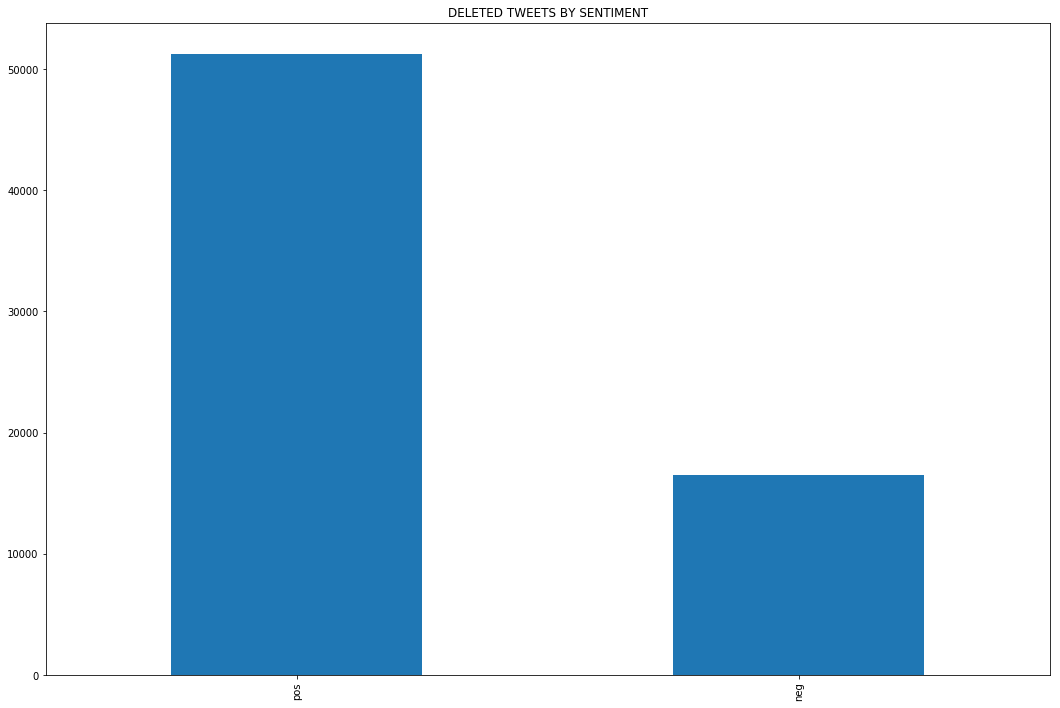

In [30]:
split_series.plot.bar(title='DELETED TWEETS BY SENTIMENT')

***
## *CONCLUSION*

The classifier split the tweets into 51,260 positive tweets and 16,496 negative tweets. The weight toward the positive class may be related to the political context of the tweets: politicians are likely to use twitter to express positive sentiment about their actions or things they support, such as policy or legislation. This is perhaps unique to political tweets in that the regular population's tweets are likely to be more personal and quotidian in nature, and therefore may not be so heavily weighted toward the positive class. Also, as stated above, the addition of a neutral class would change this distribution significantly, although we would expect more positive classes to change to neutral in that case than negative to neutral.